## Predicting Survival with Titanic Dataset
***

[Link to Kaggle challenge/dataset](https://www.kaggle.com/c/titanic)



In [3]:
import os

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Main Steps


* Look at the big picture
* Get the data
* Discover and visualize the data to gain insights (analyze, identify patterns, and explore the data)
* Prepare the data for Machine Learning algorithms (wrangle, prepare, cleanse the data.)
* Select a model and train it
* Fine-tune your model
* Present your solution (visualize, report, and present the problem solving steps and final solution)
* Launch, monitor, and maintain your system (or supply or submit the results in this case)

In [202]:
! git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../../titanic-survival.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	../../dt.csv
	../../nn.csv

no changes added to commit (use "git add" and/or "git commit -a")


## Get the data
***

In [140]:
# to mount google drive for colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
path_to_data = "/content/drive/My Drive/ml_projects/predicting-titanic-survival/data/titanic/"

In [42]:
train_df = pd.read_csv(path_to_data + "train.csv")
test_df = pd.read_csv(path_to_data + "test.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Discover and visualize the data
***

In [43]:
# quick description of data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [44]:
# find out what categories exist and how many examples belong to each
train_df["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [45]:
# find out what categories exist for Embarked
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

38% of passengers survived, our dataset isn't too unbalanced.

In [169]:
train_df["Survived"].mean()

0.3838383838383838

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.
* Nominal: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.
* Continous: Age, Fare. Discrete: SibSp, Parch.

In [13]:
# show summary of the numerical attributes
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<function matplotlib.pyplot.show>

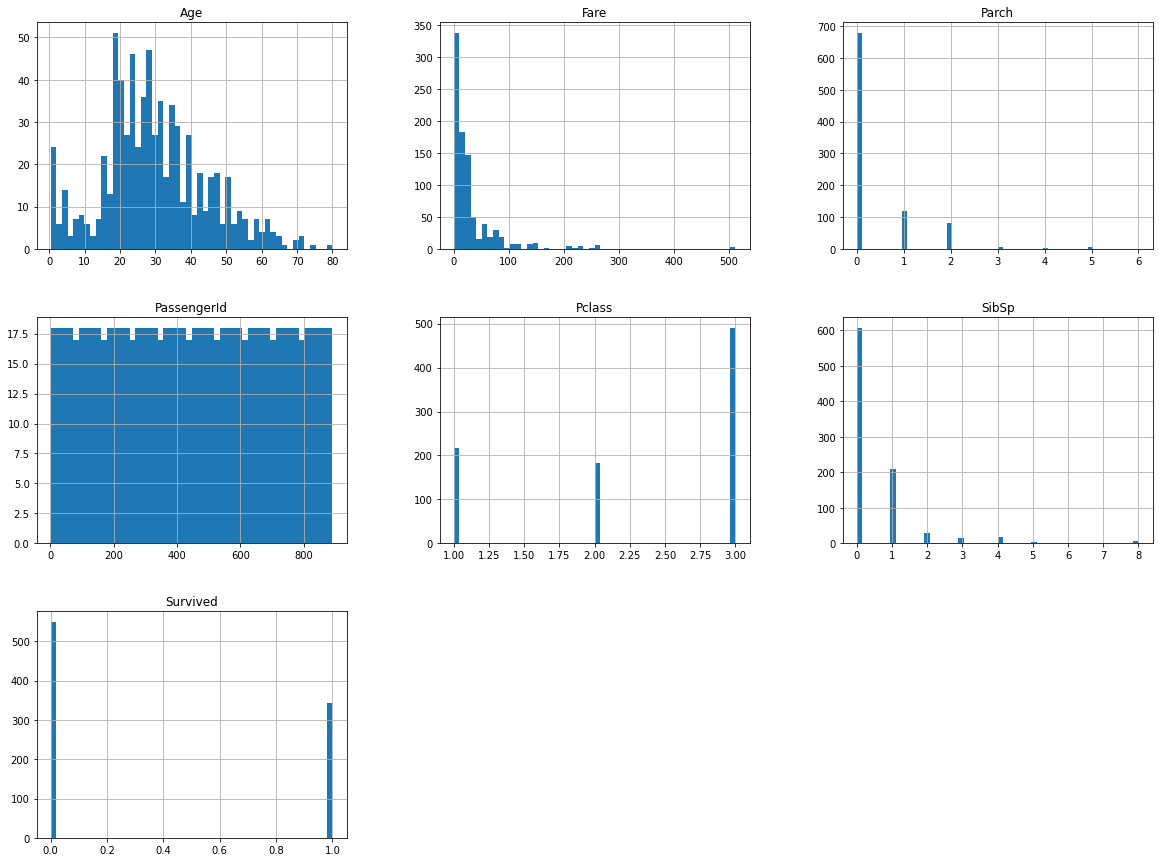

In [14]:
# plot histogram for each numerical attribute
train_df.hist(bins=50, figsize=(20,15))
plt.show

In [15]:
# show summary of categorical attributes
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Lobb, Mr. William Arthur",male,347082,G6,S
freq,1,577,7,4,644


### Analyze by pivoting features

To confirm some of our assumptions, let's quickly analyze some of our feature correlations by pivoting features against each other. We can only do this now for features without empty values. It also makes sense to do so only for features which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch) type.

* **Pclass**: We can see that Pclass seems to be correlated with Survival.
* **Sex**: We can also see that females had a much higher Survival rate (this was an observation in the problem definition).
* **SibSp and Parch**: There seems to be 0 correlation between these features and Survival. We might try deriving a feature or a set of features from these individual features.

In [16]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [17]:
train_df[["Embarked", "Survived"]].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [18]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [19]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [20]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


### Analyze by visualizing data

Let's try to understand the correlation between our features and our solution goal (Survived). We will use a histogram chart, which is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands (Did young adults have better survival rate?)

We will use Seaborn's [FacetGrid](https://seaborn.pydata.org/tutorial/axis_grids.html) class which visualizes the distribution of a variable or the relationship between multiple variables separately within subsets of your dataset.
The class is used by initializing a FacetGrid object with a dataframe and the names of the variables that will form the row, column, or hue dimensions of the grid. These variables should be categorical or discrete, and then the data at each level of the variable will be used for a facet along that axis. 



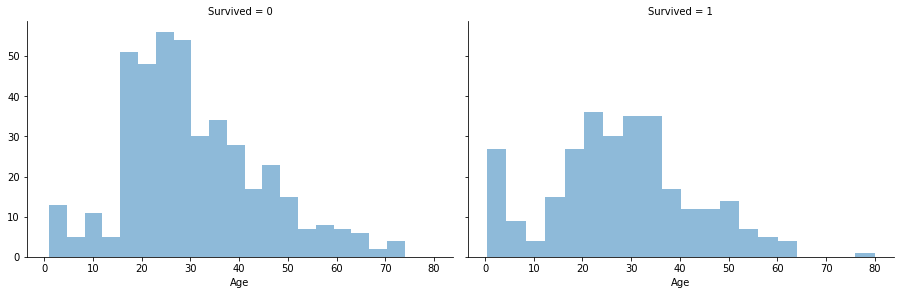

In [21]:
grid = sns.FacetGrid(train_df, col='Survived',  height=4.2, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

It seems like children ages 0-5 were more likely so survive. Unfortunately, there were many casualties in the 15-25 age group. Let's keep Age as a feature.

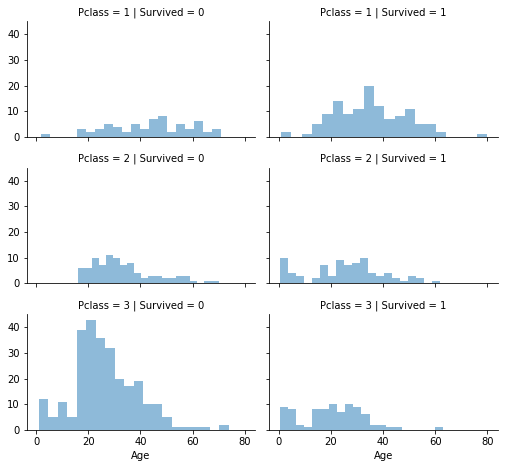

In [22]:
# combine multiple features to identify correlation
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

We can observe that Pclass 3 had the most amount of passengers, but most did not survive. Infants in Pclass 2 and Pclass 3 mostly survived. It seems like in Pclass 1, most of the passengers survived.


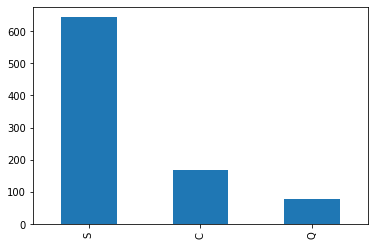

In [23]:
# plot bar chart of categorical feature Embarked
train_df['Embarked'].value_counts().plot(kind='bar')

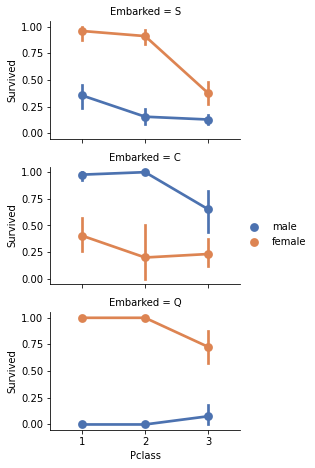

In [24]:
# correlate categorical features Embarked, Sex with our solution goal Survived
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=None, hue_order=None)
grid.add_legend()

Generally, females were much more likely to have surived. The exception to this rule is when Embarked=C (Cherbourg). 
There could exist a correlation between Pclass and Embarked and a correlation between PClass and Survived, not necessarily direct a correlation between Embarked and Survived.

Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Embarked could important so let's complete the feature for model training.

**Note:**
Point plots can be more useful than bar plots for focusing comparisons between different levels of one or more categorical variables. They are particularly adept at showing interactions: how the relationship between levels of one categorical variable changes across levels of a second categorical variable.


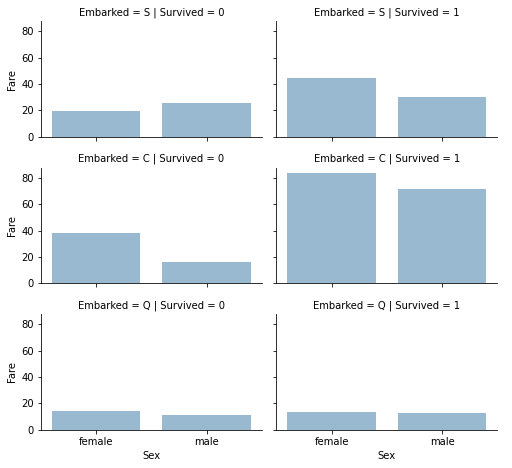

In [25]:
# correlate categorical features Embarked, Survived, Sex with numerical feature Fare
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None, order=None)
grid.add_legend()

Seems like passengers with higher fare were more likely to survive. It looks like Embarked port is correlated with survival rate

## Prepare the data
***

### **Drop features**

In [46]:
#print(train_df.info())
#print(test_df.info())

In [47]:
# train set
train_df = train_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)

# test set
test_ids = test_df['PassengerId']
test_df = test_df.drop(['Ticket', 'Cabin', 'PassengerId'], axis=1)

In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Fare      417 non-null    float64
 7   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB


### **Completing a numerical continuous feature**

Let's fill the missing *Age* feature values with the median age of our passengers.

In [49]:
mean = train_df["Age"].mean()
train_df["Age"].fillna(mean, inplace=True)

test_df["Age"].fillna(mean, inplace=True)

Fill in missing value for *Fare* in test set.

In [50]:
mean = train_df["Fare"].mean()
test_df["Fare"].fillna(mean, inplace=True)

### **Completing a categorical feature**

Let's fill in the missing *Embarked* feature values with the most common Embarked city.

In [51]:
train_df["Embarked"].value_counts()
test_df["Embarked"].value_counts()

S    270
C    102
Q     46
Name: Embarked, dtype: int64

In [52]:
train_df["Embarked"].fillna("S", inplace=True)

In [53]:
# dataframe has no more null values
print(train_df.isnull().values.any())
print(test_df.isnull().values.any())

False
False


In [54]:
print(train_df.info())
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non

In [55]:
corr_matrix = train_df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.069809
Pclass     -0.338481
Name: Survived, dtype: float64

In [56]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


### **Converting categorical variables to one-hot**

Let's convert the *Embarked* feature vector (C, Q, S) and *Sex* to one-hot encoded representations.

In [57]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# list(le.classes_)

# Sex
train_df["Sex"] = le.fit_transform(train_df["Sex"]) # male is 1, female is 0
test_df["Sex"] = le.fit_transform(test_df["Sex"])

# Embarked
train_df["Embarked"] = le.fit_transform(train_df["Embarked"]) # S is 2, C is 0, 1 is Q
test_df["Embarked"] = le.fit_transform(test_df["Embarked"])

In [58]:
enc = preprocessing.OneHotEncoder()

# Sex
train_df["Sex_F"], train_df["Sex_M"] = np.split(((enc.fit_transform(np.array(train_df["Sex"]).reshape(-1,1))).toarray()), 2, 1)
test_df["Sex_F"], test_df["Sex_M"] = np.split(((enc.fit_transform(np.array(test_df["Sex"]).reshape(-1,1))).toarray()), 2, 1)

# Embarked
temp = np.split(enc.fit_transform(np.array(train_df["Embarked"]).reshape(-1,1)).toarray(), 3, 1)
train_df["Embarked_C"], train_df["Embarked_Q"], train_df["Embarked_S"] = temp

temp = np.split(enc.fit_transform(np.array(test_df["Embarked"]).reshape(-1,1)).toarray(), 3, 1)
test_df["Embarked_C"], test_df["Embarked_Q"], test_df["Embarked_S"] = temp

# drop columns
train_df.drop(["Sex", "Embarked"], axis=1, inplace=True)
test_df.drop(["Sex", "Embarked"], axis=1, inplace=True)

In [59]:
train_df.head()

,Survived,Pclass,Name,Age,SibSp,Parch,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S
0,0,3,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,1,3,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,0,3,"Allen, Mr. William Henry",35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


### **Convert continuous numerical features to ordinal**

Let's use binning to convert the *Fare* feature into a numerical ordinal variable.
The main motivation of this is to make the model more robust and prevent overfitting, however, it has a cost to the performance.

We will do the same for the *Age* feature.

In [60]:
# Let's create farebands and see the correlation with survival
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

# same thing for test set
#test_df['FareBand'] = pd.qcut(test_df['Fare'], 4)


,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Some correlation! Let's convert fare to an ordinal feature using these bands.

In [61]:
# Convert fare feature to ordinal values based on the FareBand
combine = [train_df, test_df]

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
#test_df = test_df.drop(['FareBand'], axis=1)
    

In [62]:
#train_df["Fare"].value_counts()

In [63]:
#test_df.head()

In [64]:
corr_matrix = train_df.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived      1.000000
Sex_F         0.543351
Fare          0.295875
Embarked_C    0.168240
Parch         0.081629
Embarked_Q    0.003650
SibSp        -0.035322
Age          -0.069809
Embarked_S   -0.149683
Pclass       -0.338481
Sex_M        -0.543351
Name: Survived, dtype: float64

Let's bin the *Age* feature and convert it to a ordinal variable.

In [65]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.344168
2,"(32.252, 48.168]",0.404255
3,"(48.168, 64.084]",0.434783
4,"(64.084, 80.0]",0.090909


In [66]:
combine = [train_df, test_df]

for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    dataset['Age'] = dataset['Age'].astype(int)

train_df = train_df.drop(['AgeBand'], axis=1)

In [67]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#print(train_df.head())
#print("\n")

#corr_matrix = train_df.corr()
#corr_matrix["Survived"].sort_values(ascending=True)

In [68]:
#train_df[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Survived', ascending=False)

In [69]:
#corr_matrix = train_df.corr()
#corr_matrix["Survived"].sort_values(ascending=False)

### **Feature engineering**

***FamilySize***

Let's create a new feature called *FamilySize*. We can make a reasonable assumption that large families that are grouped together are more likely to get rescued than people traveling alone.

In [70]:
combine = [train_df, test_df]

for dataset in combine:
  dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp']
  #dataset.drop(['Parch', 'SibSp'], axis=1, inplace=True)

In [71]:
combine = [train_df, test_df]

for dataset in combine:
  dataset['isAlone'] =  ((dataset['Parch'] | dataset['SibSp'])==0).astype(int)
  dataset.drop(['Parch', 'SibSp'], axis=1, inplace=True)

Let's try a new feature age*pclass

In [72]:
combine = [train_df, test_df]

for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass


In [73]:
test_df.head()

,Pclass,Name,Age,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S,FamilySize,isAlone,Age*Class
0,3,"Kelly, Mr. James",2,0,0.0,1.0,0.0,1.0,0.0,0,1,6
1,3,"Wilkes, Mrs. James (Ellen Needs)",2,0,1.0,0.0,0.0,0.0,1.0,1,0,6
2,2,"Myles, Mr. Thomas Francis",3,1,0.0,1.0,0.0,1.0,0.0,0,1,6
3,3,"Wirz, Mr. Albert",1,1,0.0,1.0,0.0,0.0,1.0,0,1,3
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,1,1.0,0.0,0.0,0.0,1.0,2,0,3


***Title***

We can see that each name has a title. Most are Miss. or Mrs. but some of them are more sophisticated like Officer, Lady. This can give us additional information about passenger social status. Let's parse these names and extract the title into one-hot encoded form.

In [74]:
# these are most of the titles in the dataset
title_dict = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

# this function takes a name and returns the title or 'Other'
def extract_title(name):
  name = name.replace(',', '')
  name = name.replace('.', '')
  name = name.split()
  for word in name:
    if word in title_dict.keys():
      return title_dict[word]
  return 'Other'

combine = [train_df, test_df]
for dataset in combine:
  dataset['Title'] = dataset['Name'].map(lambda x: extract_title(x))
  dataset.drop(['Name'], axis=1, inplace=True)


In [75]:
train_df.Title.value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      4
Other        1
Name: Title, dtype: int64

In [76]:
test_df.Title.value_counts()

Mr         240
Miss        78
Mrs         73
Master      21
Officer      5
Other        1
Name: Title, dtype: int64

Let's one-hot encode the *Title* feature.

In [77]:
combine = [train_df, test_df]
datasets = []
for dataset in combine:
  title_df = pd.get_dummies(dataset['Title'], prefix='Title')
  datasets.append((pd.concat([dataset, title_df], axis=1)).drop(['Title'], axis=1))

# reassign dataframes
train_df = datasets[0]
test_df = datasets[1]

In [78]:
# add empty royalty row for test set
title_royalty = pd.Series(np.zeros(418).astype(int))
test_df['Title_Royalty'] = title_royalty

In [79]:
train_df.head()

,Survived,Pclass,Age,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S,FamilySize,isAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Other,Title_Royalty
0,0,3,1,0,0.0,1.0,0.0,0.0,1.0,1,0,3,0,0,1,0,0,0,0
1,1,1,2,3,1.0,0.0,1.0,0.0,0.0,1,0,2,0,0,0,1,0,0,0
2,1,3,1,1,1.0,0.0,0.0,0.0,1.0,0,1,3,0,1,0,0,0,0,0
3,1,1,2,3,1.0,0.0,0.0,0.0,1.0,1,0,2,0,0,0,1,0,0,0
4,0,3,2,1,0.0,1.0,0.0,0.0,1.0,0,1,6,0,0,1,0,0,0,0


### **Feature scaling**

For each feature, let's set mean of the distribution to 0 and standard deviation to 1 for each feature. This is done in order to help avoid giving any feature loss functions.


**Why do we need feature scaling?**

Machine learning algorithms like linear regression, logistic regression, neural network, etc. that use gradient descent as an optimization technique require data to be scaled. Take a look at the formula for gradient descent below:

$\theta_j = \alpha * \frac{1}{m} \sum_{i=1}^{m} h_{\theta} (x^{(i)} - y^{(i)})x^{(i)}_{j}$

The presence of feature value X in the formula will affect the step size of the gradient descent. The difference in ranges of features will cause different step sizes for each feature. To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we scale the data before feeding it to the model.

Distance algorithms like KNN, K-means, and SVM are most affected by the range of features. This is because behind the scenes **they are using distances between data points to determine their similarity**. If we want all features to contribute equally, scale your features.

In [178]:
# get numpy arrays for input X and labels y 
y_train = (train_df['Survived']).values
X_train = (train_df.drop(['Survived'], axis=1)).values
X_columns = (train_df.drop(['Survived'], axis=1)).columns

# get numpy array for input X_test
X_test_columns = test_df.columns
X_test = test_df.values

In [179]:
# standardize input features X
scaler = StandardScaler()
#scaler = MinMaxScaler()

# train set

X_train = scaler.fit_transform(X_train)

# test set
X_test = scaler.transform(X_test)

In [180]:
# get back scaled dataframe for observation
train_df_scaled = pd.DataFrame(X_train)
train_df_scaled.columns = X_columns


test_df_scaled = pd.DataFrame(X_test)
test_df_scaled.columns = X_test_columns
test_df_scaled.head()

,Pclass,Age,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S,FamilySize,isAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Other,Title_Royalty
0,0.827377,0.873365,-1.346777,-0.737695,0.737695,-0.482043,3.251373,-1.623803,-0.560975,0.811922,1.836831,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
1,0.827377,0.873365,-1.346777,1.355574,-1.355574,-0.482043,-0.307562,0.615838,0.059160,-1.231645,1.836831,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.03352,-0.067153
2,-0.369365,2.104643,-0.451938,-0.737695,0.737695,-0.482043,3.251373,-1.623803,-0.560975,0.811922,1.836831,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
3,0.827377,-0.357914,-0.451938,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.560975,0.811922,0.148437,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
4,0.827377,-0.357914,-0.451938,1.355574,-1.355574,-0.482043,-0.307562,0.615838,0.679295,-1.231645,0.148437,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.03352,-0.067153


In [181]:
test_df_scaled.head()

,Pclass,Age,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S,FamilySize,isAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Other,Title_Royalty
0,0.827377,0.873365,-1.346777,-0.737695,0.737695,-0.482043,3.251373,-1.623803,-0.560975,0.811922,1.836831,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
1,0.827377,0.873365,-1.346777,1.355574,-1.355574,-0.482043,-0.307562,0.615838,0.059160,-1.231645,1.836831,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.03352,-0.067153
2,-0.369365,2.104643,-0.451938,-0.737695,0.737695,-0.482043,3.251373,-1.623803,-0.560975,0.811922,1.836831,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
3,0.827377,-0.357914,-0.451938,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.560975,0.811922,0.148437,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
4,0.827377,-0.357914,-0.451938,1.355574,-1.355574,-0.482043,-0.307562,0.615838,0.679295,-1.231645,0.148437,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.03352,-0.067153


In [182]:
train_df_scaled.head()

,Pclass,Age,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S,FamilySize,isAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Other,Title_Royalty
0,0.827377,-0.357914,-1.346777,-0.737695,0.737695,-0.482043,-0.307562,0.615838,0.059160,-1.231645,0.148437,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153
1,-1.566107,0.873365,1.337738,1.355574,-1.355574,2.074505,-0.307562,-1.623803,0.059160,-1.231645,-0.414361,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.03352,-0.067153
2,0.827377,-0.357914,-0.451938,1.355574,-1.355574,-0.482043,-0.307562,0.615838,-0.560975,0.811922,0.148437,-0.216803,1.960202,-1.175735,-0.407714,-0.143592,-0.03352,-0.067153
3,-1.566107,0.873365,1.337738,1.355574,-1.355574,-0.482043,-0.307562,0.615838,0.059160,-1.231645,-0.414361,-0.216803,-0.510152,-1.175735,2.452702,-0.143592,-0.03352,-0.067153
4,0.827377,0.873365,-0.451938,-0.737695,0.737695,-0.482043,-0.307562,0.615838,-0.560975,0.811922,1.836831,-0.216803,-0.510152,0.850532,-0.407714,-0.143592,-0.03352,-0.067153


## Select, train, and fine-tune models
***

### **Logistic Regression**
Let's start with a *Logistic Regression* classifier.

In [91]:
poly = PolynomialFeatures(degree = 2, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)

log_reg = LogisticRegression(max_iter=10000)
#log_reg.fit(X_poly, y_train)
#acc_log_reg = log_reg.score(X_poly, y_train)
#print("Training accuracy:", score)

In [92]:
# Grid Search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }
grid_search = GridSearchCV(log_reg, param_grid, cv=10)
grid_search.fit(X_poly, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=10000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [93]:
# get best parameters and estimator
print("Best parameters:", grid_search.best_params_)
log_reg = grid_search.best_estimator_

# get mean cross-validated score of the best_estimator
best_result = grid_search.best_score_
print("Training accuracy:", log_reg.score(X_poly, y_train))
print("Cross-validation accuracy:", best_result)

Best parameters: {'C': 0.01}
Training accuracy: 0.8428731762065096
Cross-validation accuracy: 0.8237952559300874


In [ ]:
# cross-validation without GridSearchCV


# cv_score = cross_validate(log_reg, X_poly, y_train, cv=10, scoring="accuracy", return_train_score=True)
# print("Training accuracy:", cv_score['train_score'].mean())
# print("Validation accuracy:", cv_score['test_score'].mean())

In [ ]:
# get coefficients to see if it matches with earlier correlations

# log_reg.coef_[0].shape


### **Support Vector Machine**
Let's try using a *Support Vector Machine* classifier.

In [96]:
svc = SVC()


# Grid Search
param_grid = {'C': [0.1, 1, 10, 100, 1000, 10000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

grid_search = GridSearchCV(svc, param_grid, cv=10) 
grid_search.fit(X_train, y_train) 


#svc.fit(X_train, y_train)
# acc_svc = svc.score(X_train, y_train)
# print("Training accuracy:", acc_svc)
# print(svc.score(X_train, y_train))

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000, 10000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [97]:
# get best parameters and estimator
print("best parameters", grid_search.best_params_)
svc = grid_search.best_estimator_

# get mean cross-validated score of the best_estimator
best_result = grid_search.best_score_
print("Training accuracy:", svc.score(X_train, y_train))
print("Cross-validation accuracy:", best_result)

best parameters {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
Training accuracy: 0.8338945005611672
Cross-validation accuracy: 0.8305493133583021


In [ ]:
# cross validation without GridSearchCV

# cv_score = cross_validate(svc, X_train, y_train, cv=10, scoring="accuracy", return_train_score=True)
# print("Training accuracy:", cv_score['train_score'].mean())
# print("Validation accuracy:", cv_score['test_score'].mean())

### **k-Nearest Neighbors**
Next let's use a *k-Nearest Neighbors* algorithm for classfication.

In [170]:
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7] }
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=10) 
grid_search.fit(X_train, y_train) 


# knn.fit(X_train, y_train)
# cv_score = cross_validate(knn, X_train, y_train, cv=10, scoring="accuracy", return_train_score=True)
# print("Training accuracy:", cv_score['train_score'].mean())
# print("Validation accuracy:", cv_score['test_score'].mean())

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [171]:
# get best parameters and estimator
print("Best parameters:", grid_search.best_params_)
knn = grid_search.best_estimator_

# get mean cross-validated score of the best_estimator
best_result = grid_search.best_score_
print("Training accuracy:", knn.score(X_train, y_train))
print("Cross-validation accuracy:", best_result)

best parameters {'n_neighbors': 6}
training accuracy: 0.8484848484848485
cross-validation accuracy: 0.8237827715355805


### **Decision Tree**

In [176]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'], 'ccp_alpha': np.arange(0, 1, 0.001).tolist()}
decision_tree = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree, param_grid, cv=10) 
grid_search.fit(X_train, y_train)


# decision_tree.fit(X_train, y_train)
# cv_score = cross_validate(decision_tree, X_train, y_train, cv=10, scoring="accuracy", return_train_score=True)
# print("Training accuracy:", cv_score['train_score'].mean())
# print("Validation accuracy:", cv_score['test_score'].mean())

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='d...
             param_grid={'ccp_alpha': [0.0, 0.001, 0.002, 0.003, 0.004, 0.005,
                   

In [177]:
# cross-validation method

# decision_tree = DecisionTreeClassifier()

# decision_tree.fit(X_train, y_train)
# cv_score = cross_validate(decision_tree, X_train, y_train, cv=10, scoring="accuracy", return_train_score=True)
# print("Training accuracy:", cv_score['train_score'].mean())
# print("Validation accuracy:", cv_score['test_score'].mean())

Training accuracy: 0.8902610826242757
Validation accuracy: 0.8103745318352059


In [98]:
# get best parameters and estimator
print("Best parameters:", grid_search.best_params_)
decision_tree = grid_search.best_estimator_

# get mean cross-validated score of the best_estimator
best_result = grid_search.best_score_
print("Training accuracy:", decision_tree.score(X_train, y_train))
print("Cross-validation accuracy:", best_result)

Best parameters: {'C': 10000, 'gamma': 0.0001, 'kernel': 'rbf'}
Training accuracy: 0.8338945005611672
Cross-validation accuracy: 0.8305493133583021


### **Random Forests**

In [99]:
random_forest = RandomForestClassifier(random_state=25)

#random_forest.fit(X_train, y_train)
#random_forest.score(X_train, y_train)
# cv_score = cross_validate(random_forest, X_train, y_train, cv=10, scoring="accuracy", return_train_score=True)
# print("Training accuracy:", cv_score['train_score'].mean())
# print("Validation accuracy:", cv_score['test_score'].mean())

In [100]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid_search = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=25,
                                  

In [102]:
# get best parameters and estimator
print("Best parameters:", grid_search.best_params_)
random_forest = grid_search.best_estimator_

# get mean cross-validated score of the best_estimator
best_result = grid_search.best_score_
print("Training accuracy:", random_forest.score(X_train, y_train))
print("Cross-validation accuracy:", best_result)

Best parameters: {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 200}
Training accuracy: 0.8529741863075196
Cross-validation accuracy: 0.8316552633230808


### **Neural Network**

Let's try using a *deep feedforward neural network* (DNN) using the Keras API for TensorFlow.

In [103]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [104]:
from keras.utils import to_categorical

# one hot encode labels
y_one_hot = to_categorical(y_train)

In [105]:
train_df_scaled.shape

(891, 18)

Note on **regularization**: 𝐿1  versus 𝐿2

𝐿2 treats outliers a little more thoroughly - returning a larger error for those points. Have a look here for more detailed comparisons.

In [108]:
# define the keras model
model = Sequential()
model.add(Dense(128, input_shape=(18,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [109]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               2432      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 19,202
Trainable params: 19,202
Non-trainable params: 0
_________________________________________________________________


In [110]:
# compile the keras model
# try learning rates 1/100 to 1/10000
opt = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [111]:
# fit the keras model on the dataset
#model.fit(X_train, y_train, epochs=100, batch_size=32)
model.fit(X_train, y_one_hot, validation_split=0.15, epochs=95, batch_size=32)

# check why final loss/accuracy is average of all batch losses 
# and not the one for the final batch

Epoch 1/95
24/24 [==============================] - 0s 9ms/step - loss: 0.5593 - accuracy: 0.7067 - val_loss: 0.4079 - val_accuracy: 0.8209
Epoch 2/95
24/24 [==============================] - 0s 2ms/step - loss: 0.4416 - accuracy: 0.8137 - val_loss: 0.3766 - val_accuracy: 0.8582
Epoch 3/95
24/24 [==============================] - 0s 3ms/step - loss: 0.4129 - accuracy: 0.8375 - val_loss: 0.3817 - val_accuracy: 0.8582
Epoch 4/95
24/24 [==============================] - 0s 3ms/step - loss: 0.4035 - accuracy: 0.8336 - val_loss: 0.3652 - val_accuracy: 0.8657
Epoch 5/95
24/24 [==============================] - 0s 2ms/step - loss: 0.3980 - accuracy: 0.8336 - val_loss: 0.3664 - val_accuracy: 0.8582
Epoch 6/95
24/24 [==============================] - 0s 2ms/step - loss: 0.3937 - accuracy: 0.8243 - val_loss: 0.3707 - val_accuracy: 0.8657
Epoch 7/95
24/24 [==============================] - 0s 2ms/step - loss: 0.3904 - accuracy: 0.8309 - val_loss: 0.3684 - val_accuracy: 0.8657
Epoch 8/95
24/24 [==

88
83

In [112]:
train_score = model.evaluate(X_train, y_one_hot)

28/28 [==============================] - 0s 1ms/step - loss: 0.3272 - accuracy: 0.8709


In [113]:
preds_dnn = model.predict(X_train)

In [ ]:
#preds_np.argmax(preds_dnn, axis=1)
#preds_dnn[0]

array([0.9381243 , 0.06187565], dtype=float32)

## Submit solution
***

Make predictions using DNN.

In [152]:

preds = random_forest.predict(X_test) # random forest

#preds = model.predict(X_test) # neural network
#preds = np.argmax(preds, axis=1) # do this for keras models only

pred_series = pd.Series(preds)
print(pred_series.shape)

(418,)


In [153]:
# insert predictions at end
test_df_scaled["Survived"] = preds

In [154]:
test_df_scaled.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [159]:
#test_df_scaled.insert(0, "PassengerId", test_ids)


In [160]:
test_df_scaled['PassengerId'] = test_ids

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [161]:
test_df_scaled = test_df_scaled[['PassengerId', 'Survived']]

In [162]:
test_df_scaled.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [163]:
#test_df_scaled = test_df_scaled.drop(["Pclass", "Sex", "Age", "Fare", "C", "Q", "S"], axis=1)
test_df_scaled.shape

(418, 2)

In [164]:
path_to_proj = "/content/drive/My Drive/ml_projects/predicting-titanic-survival/"

In [165]:
test_df_scaled.to_csv(path_to_proj + "dt.csv", index=False)

## Did Jack and Rose Survive?

In [183]:
np.array(train_df.head(1))

array([[0., 3., 1., 0., 0., 1., 0., 0., 1., 1., 0., 3., 0., 0., 1., 0.,
        0., 0., 0.]])

In [177]:
train_df.head()

,Survived,Pclass,Age,Fare,Sex_F,Sex_M,Embarked_C,Embarked_Q,Embarked_S,FamilySize,isAlone,Age*Class,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Other,Title_Royalty
0,0,3,1,0,0.0,1.0,0.0,0.0,1.0,1,0,3,0,0,1,0,0,0,0
1,1,1,2,3,1.0,0.0,1.0,0.0,0.0,1,0,2,0,0,0,1,0,0,0
2,1,3,1,1,1.0,0.0,0.0,0.0,1.0,0,1,3,0,1,0,0,0,0,0
3,1,1,2,3,1.0,0.0,0.0,0.0,1.0,1,0,2,0,0,0,1,0,0,0
4,0,3,2,1,0.0,1.0,0.0,0.0,1.0,0,1,6,0,0,1,0,0,0,0


In [ ]:
jack_arr = np.array([[]])